In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit

\begin{align*}
\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2}\frac{\partial^2 y}{\partial t^2} - \gamma\frac{\partial y}{\partial t} - l^2\frac{\partial^4 y}{\partial x^4} = 0\\
y(0,t) = y(L,t) = 0\\
y(x,0) = f(x)
\end{align*}

Parameters
- $c$ is the speed of the wave
- $\gamma$ damping constant
- $l$ characteristic length (dimensionless, stiffness term)

There is a central finite difference formula 
$$
    \delta^n_h[f](x) = \sum^n_{i=0}(-1)^{n-i}{n\choose i}f(x+(\frac{n}{2}-i)h)
$$

\begin{align*}
    \frac{y^m_{j+1}-2y^m_j+y^m_{j-1}}{\Delta x^2} - \frac{1}{c^2}\frac{y^{m+1}_j-2y^m_j+y^{m-1}_j}{\Delta t^2} - \gamma\frac{y^{m+1}_j-y^{m-1}_j}{2\Delta t}-l^2\frac{y^m_{j-2}-4y^m_{j-1}+6y^m_j-4y^m_{j+1}+y^m_{j+2}}{\Delta x^4} = 0
\end{align*}

You see $m$ is about time, $j$ is about space

Then 

\begin{align*}
y^{m+1}_j = \left[\frac{1}{c^2\Delta t^2}+\frac{\gamma}{2\Delta t}\right]^{-1}\left[\frac{y^m_{j+1}-2y^m_j+y^m_{j-1}}{\Delta x^2} - \frac{1}{c^2}\frac{-2y^m_j+y^{m-1}_j}{\Delta t^2} + \gamma\frac{y^{m-1}_j}{2\Delta t}-l^2\frac{y^m_{j-2}-4y^m_{j-1}+6y^m_j-4y^m_{j+1}+y^m_{j+2}}{\Delta x^4}\right]
\end{align*}


Guitar string length $L=0.7$

Fundamental frequency $\displaystyle f_0 = \frac{c}{2L} = 220\text{Hz}$

Speed $c=308$ m/s

Choose $N_x = 101, N_t = 500000$ so $\Delta x = 0.7\text{cm},\ \Delta t = 2\times 10^{-6}\text{s}$

From testing $l=2\times 10^{-6}$ and $\gamma=2.6\times 10^{-5}$

In [142]:
Nx = 101

duration = 3
dt = 2e-06
Nt = int(duration / dt)
L = 0.7
dx = L/(Nx-1)

c = 308
l=2e-6
gamma=2.6e-5

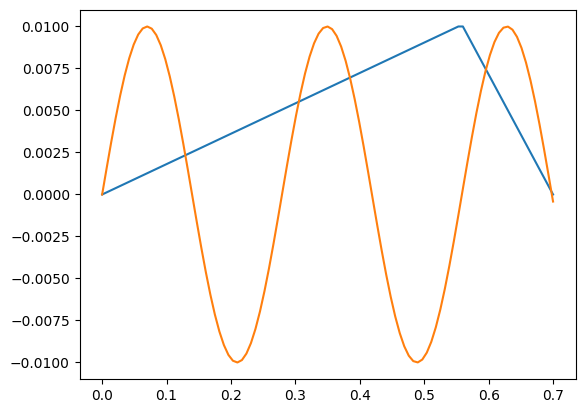

In [143]:
ya = np.linspace(0, 0.01, 80)
yb = np.linspace(0.01, 0, Nx-80)
y0 = np.concatenate([ya,yb])
x = np.linspace(0,L,Nx)
y1 = 0.01 * np.sin(x*22.5)
plt.plot(x,y0)
plt.plot(x,y1)

In [144]:
sol = np.zeros((Nt, Nx))
sol[0] = y0
sol[1] = y0
sol2 = np.zeros((Nt, Nx))
sol2[0] = y1
sol2[1] = y1

In [145]:
@numba.jit("f8[:,:](f8[:,:], f8, f8, f8, f8)", nopython=True, nogil=True)
def compute(y, dt, dx, l, gamma):
    outer_factor = 1/(1/(c * dt)**2+gamma/2/dt)
    times = len(y)
    length = len(y[0])
    for m in range(1,times-1):
        for j in range(2,length-2):
            f = (y[m][j+1]-2*y[m][j]+y[m][j-1])/dx**2
            g = -(y[m-1][j]-2*y[m][j])/(c**2 * dt**2)
            h = gamma * y[m-1][j] / 2/dt
            i = - (l/dx**2)**2 * (y[m][j-2]-4*y[m][j-1]+6*y[m][j]-4*y[m][j+1]+y[m][j+2])
            y[m+1][j] = outer_factor * (f+g+h+i)
    return y

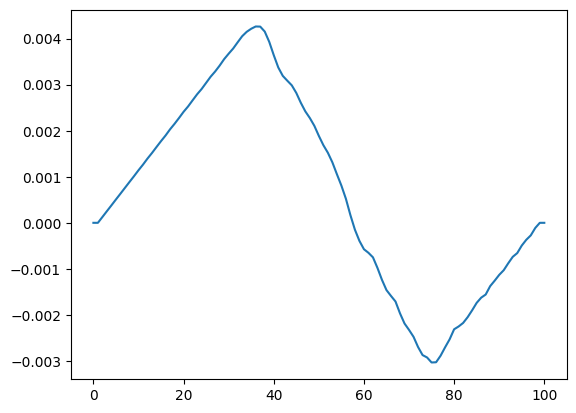

In [146]:
sol = compute(sol, dt, dx, l, gamma)
plt.plot(sol[500])
sol2 = compute(sol2, dt, dx, l, gamma)

In [147]:
def anim(i):
    ax.clear()
    ax.set_ylim(-0.01,0.01)
    ax.set_xlim(0,L)
    plt.figure(figsize=(20,3))
    ax.plot(x,sol[10*i])

def anim2(i):
    ax.clear()
    ax.set_ylim(-0.01,0.01)
    ax.set_xlim(0,L)
    plt.figure(figsize=(20,3))
    ax.plot(x,sol2[10*i])

# fig, ax = plt.subplots(1,1)
# ani = animation.FuncAnimation(fig,anim,500)
# ani.save('string.gif',writer='pillow',fps=24)
# ani2 = animation.FuncAnimation(fig,anim2,500)
# ani2.save('string2.gif',writer='pillow',fps=24)

In [148]:
def integral(n, y):          # is the solution we just get
    sin_arr = np.sin(n*np.linspace(0,np.pi,Nx))
    return np.array([sum(sin_arr*s) for s in y])      #array of relative amplitude for the nth harmonic at all times

In [149]:
numberoHarmonics = 20

In [238]:
hms = np.array([integral(n,sol) for n in range(1,numberoHarmonics+1)])
hms2 = np.array([integral(n,sol2) for n in range(1,numberoHarmonics+1)])

KeyboardInterrupt: 

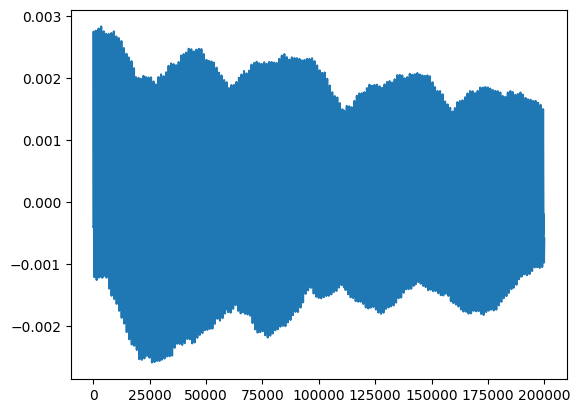

In [151]:
plt.plot(hms[9][:200000:])

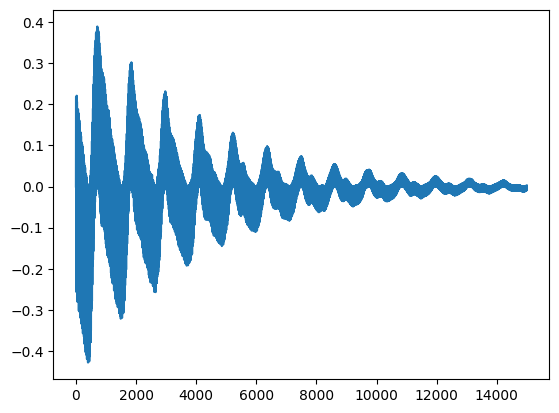

In [237]:
t = np.linspace(0,duration,Nt)
tot = np.array(sum(hms[i]*np.sin((i+1)*np.pi*c*t/L) for i in range(numberoHarmonics)))
tot = tot[::10].astype(np.float32)     # 50k, usual mp4 needs 48 kHz
plt.plot(tot[::10])

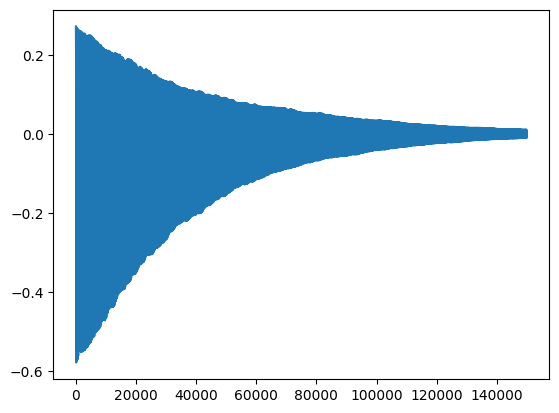

In [229]:
plt.plot(np.array(sum(hms))[::10].astype(np.float32))

In [154]:
from scipy.io import wavfile
from IPython.display import Audio

In [230]:
wavfile.write('sound.wav',50000,tot)

In [235]:
wavfile.write('sound2.wav',50000,np.array(sum(hms))[::10].astype(np.float32))

In [232]:
Audio('sound.wav')

In [236]:
Audio('sound2.wav')